In [12]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [15]:
data = pd.read_csv('result_gemeente.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6508 entries, 0 to 6507
Data columns (total 72 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6508 non-null   int64  
 1   last_scraped                 6508 non-null   object 
 2   host_id                      6508 non-null   int64  
 3   host_since                   6508 non-null   object 
 4   host_is_superhost            6508 non-null   int64  
 5   neighbourhood_cleansed       6508 non-null   object 
 6   host_listings_count          6508 non-null   int64  
 7   latitude                     6508 non-null   float64
 8   longitude                    6508 non-null   float64
 9   property_type                6508 non-null   object 
 10  room_type                    6508 non-null   object 
 11  accommodates                 6508 non-null   int64  
 12  bathrooms                    6508 non-null   float64
 13  bathrooms_text    

## Data Preprocessing

In [16]:
data = pd.read_csv('result_gemeente.csv')
data = data.dropna()

# Apply log transformation to the target variable
data['logprice'] = np.log(data['price'])

# Separate target and features
y = data['logprice']

features = (["distance_to_city_center", "host_is_superhost", "accommodates", "bathrooms", "bedrooms", "beds"
            , 'Dishwasher', 'Washer', 'Dryer', 'Microwave',
            'Freezer', 'Private entrance', 'Coffee maker', 'Oven', 'Outdoor dining area', 'Private patio or balcony',
            'Luggage dropoff allowed', 'Bathtub', 'Blender', 'Paid parking on premises',
            'Air conditioning', 'Waterfront', 'Pets allowed', 'Canal view', 'Free parking on premises', 'Bikes', 'Safe',
            "inwoners", "gemiddeld huishoudinkomen", "gemiddelde woningwaarde",
            "number_of_reviews", "review_scores_rating", "supermarkt - afstand",
            'treinstation - afstand', 'attractiepark - afstand', 'zwembad - afstand', 'bioscoop - afstand', 'museum - afstand',
            'café - afstand', 'hotel - afstand', 'restaurant - afstand', "property_type"])
X = data[features]

# Convert categorical variables to dummy variables
categorical_columns = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Hyperparameter choice

In [ ]:
# Optional - computationally intensive block, 'optimal' hyperparameters used below

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print('Best Parameters:', grid_search.best_params_)
print('Best R^2 Score:', grid_search.best_score_)

## Random Forest Regression

In [17]:
# Random Forest
rf = RandomForestRegressor(max_depth=None,
                           min_samples_leaf = 2,
                           min_samples_split = 5,
                           n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R^2 Score: {r2:.4f}')

# Feature Importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

Mean Squared Error: 0.0966
R^2 Score: 0.6240


#### Feature Importance

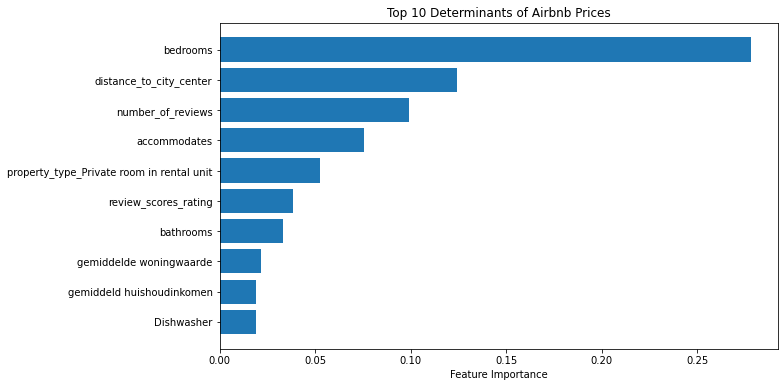

In [18]:
# Plot the top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10))
plt.xlabel('Feature Importance')
plt.title('Top 10 Determinants of Airbnb Prices')
plt.gca().invert_yaxis()
plt.show()

#### Prediction and Residual analysis

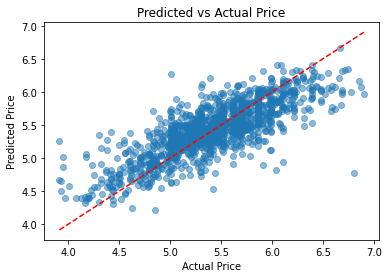

In [19]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')
plt.show()

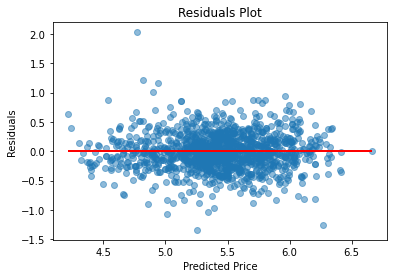

In [20]:
# Residual analysis
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linewidth=2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

#### Partial Dependency Plots

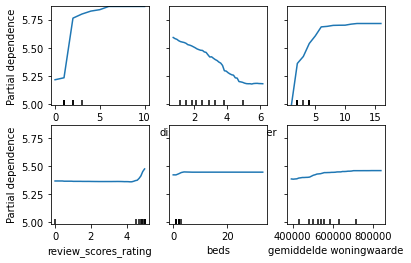

In [21]:
# Select key features to visualize
features_to_plot = ['bedrooms', 'distance_to_city_center', 'accommodates','review_scores_rating','beds','gemiddelde woningwaarde']
# Plot partial dependence
PartialDependenceDisplay.from_estimator(rf, X, features_to_plot, grid_resolution=50)
plt.show()

#### SHAP

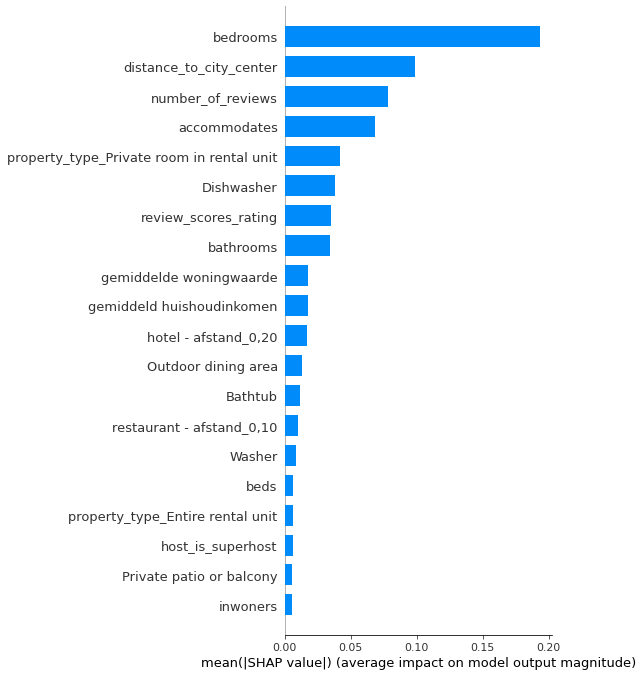

In [22]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)

# Summary plot 
shap.summary_plot(shap_values, X_train, plot_type='bar')


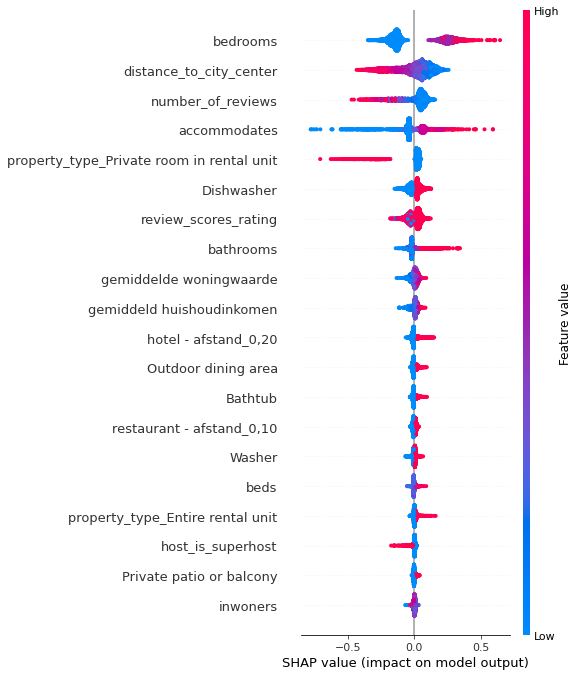

In [23]:
shap.summary_plot(shap_values, X_train)